<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка" data-toc-modified-id="Загрузка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка</a></span></li><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Первичный анализ</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборок-и-создание-пайплайна" data-toc-modified-id="Разделение-выборок-и-создание-пайплайна-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение выборок и создание пайплайна</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Финальный-вывод" data-toc-modified-id="Финальный-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Финальный вывод</a></span><ul class="toc-item"><li><span><a href="#Ход-работы" data-toc-modified-id="Ход-работы-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ход работы</a></span></li><li><span><a href="#Итоговое-заключение" data-toc-modified-id="Итоговое-заключение-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Итоговое заключение</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Импорт

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

## Подготовка

### Загрузка

In [3]:
df = pd.read_csv("/datasets/taxi.csv")

### Первичный анализ

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


**Комментарий**: В таблице у нас два признака: `datetime`-дата и время получения данных, и `num_orders` - количество заказов на момент `datetime`

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Комментарий**: Количество заказов имеет подходящий тип данных, а вот признак с датой приведем к более подходящему типу. Пропусков в данных нет

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [7]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


**Комментарий**: Теперь дата и время хранятся в более корректном типе данных.

In [8]:
df = df.resample('1H').sum()

In [9]:
df.index.is_monotonic

True

**Комментарий**: Последовательнность данных монотонная, все в порядке.

In [10]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

In [11]:
df['lag_1'] = df['num_orders'].shift(1)
df['lag_144'] = df['num_orders'].shift(144)
df['lag_1008'] = df['num_orders'].shift(1008)

In [12]:
df['rolling_mean'] = df['num_orders'].rolling(144).mean()
df = df.dropna()

In [13]:
df

,num_orders,hour,dayofweek,lag_1,lag_144,lag_1008,rolling_mean
datetime,,,,,,,
2018-04-12 00:00:00,85,0,3,98.0,83.0,124.0,59.145833
2018-04-12 01:00:00,73,1,3,85.0,70.0,85.0,59.166667
2018-04-12 02:00:00,76,2,3,73.0,45.0,71.0,59.381944
2018-04-12 03:00:00,72,3,3,76.0,54.0,66.0,59.506944
2018-04-12 04:00:00,30,4,3,72.0,52.0,43.0,59.354167
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,123.0,64.0,155.090278
2018-08-31 20:00:00,154,20,4,136.0,105.0,135.0,155.430556
2018-08-31 21:00:00,159,21,4,154.0,162.0,115.0,155.409722


**Комментарий**: Были добавлены новые признаки для более точной работы с данными и обучения модели

## Анализ

In [14]:
df

,num_orders,hour,dayofweek,lag_1,lag_144,lag_1008,rolling_mean
datetime,,,,,,,
2018-04-12 00:00:00,85,0,3,98.0,83.0,124.0,59.145833
2018-04-12 01:00:00,73,1,3,85.0,70.0,85.0,59.166667
2018-04-12 02:00:00,76,2,3,73.0,45.0,71.0,59.381944
2018-04-12 03:00:00,72,3,3,76.0,54.0,66.0,59.506944
2018-04-12 04:00:00,30,4,3,72.0,52.0,43.0,59.354167
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,123.0,64.0,155.090278
2018-08-31 20:00:00,154,20,4,136.0,105.0,135.0,155.430556
2018-08-31 21:00:00,159,21,4,154.0,162.0,115.0,155.409722


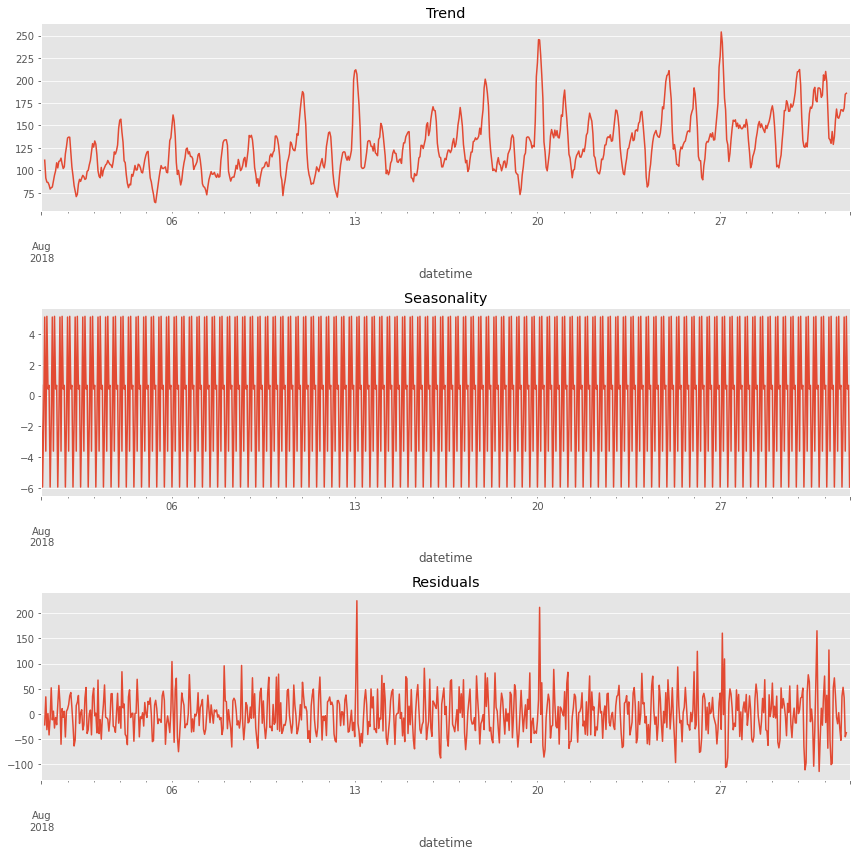

In [27]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df.loc['2018-08':'2018-08', 'num_orders'], model='additive', period=7)

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

**Комментарий**: На графиках видно, что тренд постепенно растёт, хотя сохраняются выраженные колебания. Сезонность ярко выражена и повторяется с высокой частотой, что указывает на почасовой или внутридневной паттерн. Остатки ведут себя достаточно шумно

## Обучение

### Разделение выборок и создание пайплайна

In [28]:
train, test = train_test_split(df, random_state=44, test_size=0.1, shuffle=False)

features = ['hour', 'dayofweek',
            'lag_1', 'lag_144', 'lag_1008', 'rolling_mean']

X_train = train[features]
y_train = train['num_orders']

X_test = test[features]
y_test = test['num_orders']

pipe = Pipeline([('model', DecisionTreeRegressor(random_state=44))])

param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=44)],
        'model__max_depth': [5, 10],
        'model__min_samples_split': [2, 10]
    },
    {
        'model': [LGBMRegressor(random_state=44, n_jobs=1)],
        'model__n_estimators': [700, 1500],
        'model__learning_rate': [0.01, 0.5]
    }
]

### Обучение моделей

In [29]:
tscv = TimeSeriesSplit(n_splits=8)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    cv=tscv,
    refit=True,                 
    return_train_score=False
)

grid.fit(X_train, y_train)
display("Лучший скор:", -grid.best_score_)
display("Лучшие параметры:", grid.best_params_)

Fitting 8 folds for each of 8 candidates, totalling 64 fits
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_samples_split=2; total time=   0.0s
[CV] END model=DecisionTreeRegressor(random_state=44), model__max_depth=5, model__min_

'Лучший скор:'

25.130487747412438

'Лучшие параметры:'

{'model': LGBMRegressor(learning_rate=0.01, n_estimators=700, n_jobs=1, random_state=44),
 'model__learning_rate': 0.01,
 'model__n_estimators': 700}

**Комментарий**: Лучшее значение метрики `RMSE` - `25.1` у модели `LGBMRegressor` с гиперпараметрами: `n_estimators` = 700 (кол-во деревьев в ансамбле и `learning_rate` = 0.01 (шаг обучения)

## Тестирование

In [30]:
lg = grid.best_estimator_
pred = lg.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
display("RMSE на тестовой выборке:", rmse)

'RMSE на тестовой выборке:'

39.80901110303128

**Комментарий**: Значение метрики `RMSE` - `39.8`, что удовлетворяет условия задачи

## Финальный вывод

В проекте были проанализированы исторические данные о заказах такси в аэропортах с целью прогнозирования количества заказов на следующий час.  

### Ход работы
1. **Подготовка данных**  
   - Загружены и ресемплированы данные по одному часу.  
   - Дата приведена к корректному типу и установлена в качестве индекса.  

2. **Анализ данных**  
   - Обнаружен общий рост числа заказов начиная с весны 2018 года, особенно выраженный в августе.  
   - Зафиксированы сезонные и недельные колебания: различия по месяцам, а также по дням недели.  

3. **Создание признаков**  
   - Календарные: месяц, день недели.  
   - Лаги: 1, 2 и 3 шага назад.  
   - Скользящее среднее.  

4. **Обучение моделей**  
   - Данные разделены на обучающую и тестовую выборки (10% — тест).  
   - Обучены модели `DecisionTreeRegressor` и `LightGBMRegressor`.  
   - Подбор гиперпараметров выполнен через `GridSearchCV` с метрикой RMSE.  

5. **Лучшие результаты**  
   - Лучшая модель — **LightGBMRegressor** с параметрами:  
     - `n_estimators = 700`  
     - `learning_rate = 0.01`  
   - Метрика **RMSE ≈ 40** на тестовой выборке.  
   - Условие задачи выполнено (RMSE ≤ 48).  

### Итоговое заключение
Модель **LightGBM** показала наилучшее качество прогноза и успешно решает задачу предсказания числа заказов такси на следующий час.  
Это решение позволяет планировать количество водителей в периоды пиковой нагрузки и оптимизировать работу сервиса.  

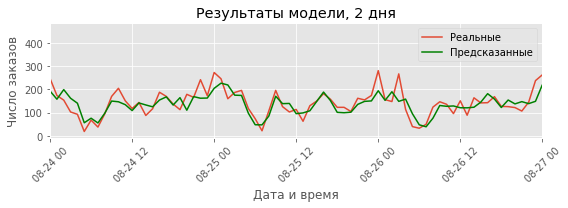

In [31]:
predictions = pd.Series(pred, index=y_test.index)

fig2, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(x=y_test.index, y=y_test.values, ax=ax, label='Реальные')
sns.lineplot(x=predictions.index, y=predictions.values, ax=ax, color='green', label='Предсказанные')

plt.xticks(rotation=90)
plt.xlim(pd.Timestamp('2018-08-24'), pd.Timestamp('2018-08-27'))

plt.title('Результаты модели, 2 дня')
plt.grid(True)
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Комментарий**: Графическое представление предскзааний данных по сравнению с реальными